In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

## Step 0: Toggle in Menu on Top: Cell > All Output > Toggle Scrolling

## Step 1: Choose Dataset

In [2]:
#dataset = "10d-valid"
#dataset = "10d-robust"
dataset = "10d-simple"

x_all = np.array(pd.read_csv(f"./train/x/x-{dataset}.csv", header=None, dtype=np.float64))
y_all = np.array(pd.read_csv(f"./train/y/y-{dataset}.csv", header=None, dtype=np.float64))
g_all = torch.load(f"./train/g/g-{dataset}-graph.pt")

# scale labels for better interpretability
y_all[:, 0] = 1000.0 * y_all[:, 0] #k CHF, so scale up by 1000
y_all[:, 1] = 100.0 * y_all[:, 1] # percentage points, so scale up by 100%

print("dataset loaded")
print(x_all.shape, y_all.shape, len(g_all))

dataset loaded
(16636, 10) (16636, 3) 16636


## Step 2 (Optional): Filter by minimum threshold for max. utilization in %

In [3]:
do_filter = False
util_threshold = 30000.0

if do_filter:
    idxs_filter = y_all[:, 1] > util_threshold
    x_all_filtered = x_all[idxs_filter, :]
    y_all_filtered = y_all[idxs_filter, :]
    g_all_filtered = list(g_all[i] for i in np.arange(x_all.shape[0])[idxs_filter].astype(int))
    print(f"\ndataset filtered by util > {util_threshold}")
else:
    print("no filter used")
    x_all_filtered = x_all
    y_all_filtered = y_all
    g_all_filtered = g_all
    
print(x_all_filtered.shape, y_all_filtered.shape, len(g_all_filtered))

no filter used
(16636, 10) (16636, 3) 16636


## Step 3: Pick random sample

In [10]:
n_samples = x_all_filtered.shape[0]
idx_sample = np.random.choice(n_samples)

print(f"\npicked idx: {idx_sample}\n")

x_sample = x_all_filtered[idx_sample, :]
y_sample = y_all_filtered[idx_sample, :]
(node_coords, edges, edges_data) = g_all_filtered[idx_sample]


picked idx: 7450



## Step 4: Check x/y data

In [5]:
print("x\n")

x_dim_names = [ "Span [m]", "Rise of Arch [m]", "Width [m]", "Hanger Spacing [m]", "Alpha0 [°]", "Tie and Arch CS-Depth [m]", "Hanger CS-Area [m^2]", "h/b Box CS [-]", "tw/h Box [-]", "tf/b Box [-]" ]
for i in range(10):
    data = "{:.6f}".format(x_sample[i])
    print(f"{data} \t {x_dim_names[i]}")

print("\ny\n")

y_dim_names = [ "Cost (CHF)", "Max. Utilisation (%)"]
for j in range(2):
    data = "{:.3f}".format(y_sample[j])
    print(f"{y_dim_names[j]}\n{data}\n")

x

158.813351 	 Span [m]
40.951535 	 Rise of Arch [m]
10.464022 	 Width [m]
2.323109 	 Hanger Spacing [m]
39.626888 	 Alpha0 [°]
1.337018 	 Tie and Arch CS-Depth [m]
0.006953 	 Hanger CS-Area [m^2]
1.546443 	 h/b Box CS [-]
0.023456 	 tw/h Box [-]
0.058053 	 tf/b Box [-]

y

Cost (CHF)
12334000.000

Max. Utilisation (%)
44.999



## Step 5: Visualize Data

<IPython.core.display.Javascript object>


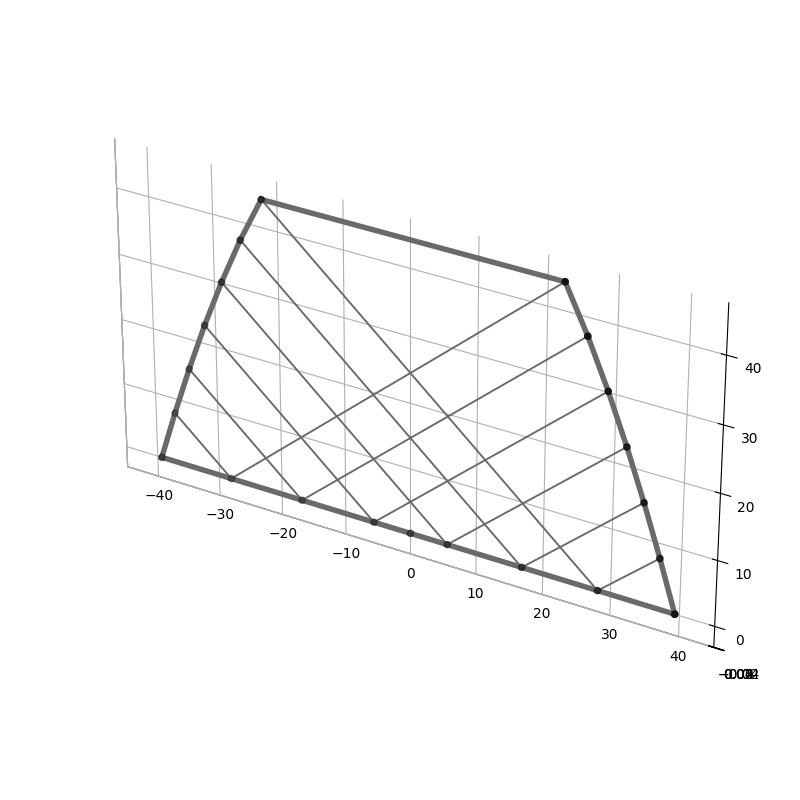

/usr/local/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  dy /= ay


In [67]:
n_edges = edges.shape[1]
final_dim = n_edges*2

# make graph bidirectional
edges_bidirect = torch.zeros((2, final_dim), dtype=torch.long)
edges_bidirect[:, :n_edges] = edges
edges_bidirect[0, n_edges:(n_edges*2)] = edges[1, :]
edges_bidirect[1, n_edges:(n_edges*2)] = edges[0, :]

graph_node_coords = node_coords.numpy()
graph_edges = edges.numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
#ax.grid(False)

fig.set_size_inches(8, 8)
fig.tight_layout()
ax.scatter(graph_node_coords[:, 0], 0.0, graph_node_coords[:, 2], color="#111")
ax.set_box_aspect(aspect = (np.max(graph_node_coords[:, 0], axis=0) - np.min(graph_node_coords[:, 0], axis=0), np.max(graph_node_coords[:, 1], axis=0) - np.min(graph_node_coords[:, 1], axis=0), np.max(graph_node_coords[:, 2], axis=0) - np.min(graph_node_coords[:, 2], axis=0)))

max_lw = np.max(edges_data.numpy()[:, 2])

for col_idx in range(graph_edges.shape[1]):
    edge_coords = graph_edges[:, col_idx]
    n1 = edge_coords[0]
    n2 = edge_coords[1]
    lw = np.log(50 * (edges_data[col_idx, 2] / max_lw))
    ax.plot(np.array([graph_node_coords[n1, 0], graph_node_coords[n2, 0]]), np.array([graph_node_coords[n1, 1], graph_node_coords[n2, 1]]), np.array([graph_node_coords[n1, 2], graph_node_coords[n2, 2]]), linewidth=lw, color='#6a6a6a')

fig.savefig("/Users/mnbucher/Downloads/bridges/bridge-1.svg", bbox_inches='tight', pad_inches=0)
#plt.show()

<IPython.core.display.Javascript object>


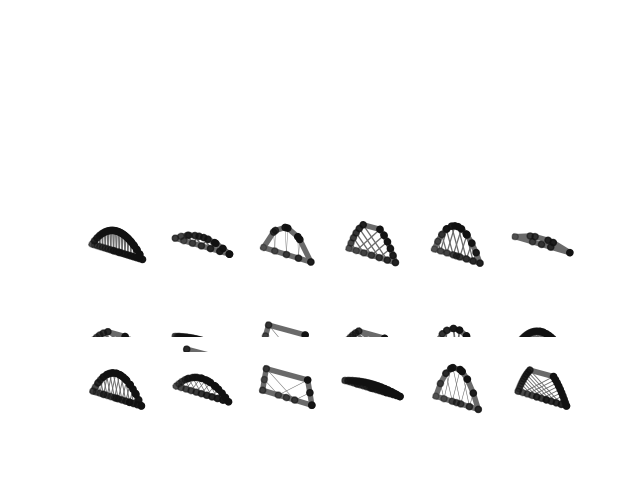

1 1
1 2
1 3
1 4
1 5
1 6
2 1
2 2
2 3
2 4
2 5
2 6
3 1
3 2
3 3
3 4
3 5
3 6
4 1
4 2
4 3
4 4
4 5
4 6


/usr/local/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  dy /= ay


In [131]:
#fig, ax = plt.subplots(1,8, projection='3d')
fig = plt.figure()
#fig.set_size_inches(12, 24)
#fig.set_size_inches(16, 16)
#fig.tight_layout()

idx=1

for row in range(1, 5):
    for col in range(1, 7):
        
        print(row, col)

        n_samples = x_all_filtered.shape[0]
        idx_sample = np.random.choice(n_samples)

        #print(f"\npicked idx: {idx_sample}\n")

        x_sample = x_all_filtered[idx_sample, :]
        y_sample = y_all_filtered[idx_sample, :]
        (node_coords, edges, edges_data) = g_all_filtered[idx_sample]

        n_edges = edges.shape[1]
        final_dim = n_edges*2

        # make graph bidirectional
        edges_bidirect = torch.zeros((2, final_dim), dtype=torch.long)
        edges_bidirect[:, :n_edges] = edges
        edges_bidirect[0, n_edges:(n_edges*2)] = edges[1, :]
        edges_bidirect[1, n_edges:(n_edges*2)] = edges[0, :]

        graph_node_coords = node_coords.numpy()
        graph_edges = edges.numpy()

        #fig = plt.figure()
        #ax[dim] = fig.add_subplot(111, projection='3d')
        ax = fig.add_subplot(row, 6, idx, projection='3d')
        #print(row)
        #print(row*col)

        ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
        #ax.grid(False)

        ax.scatter(graph_node_coords[:, 0], 0.0, graph_node_coords[:, 2], color="#111")
        ax.set_box_aspect(aspect = (np.max(graph_node_coords[:, 0], axis=0) - np.min(graph_node_coords[:, 0], axis=0), np.max(graph_node_coords[:, 1], axis=0) - np.min(graph_node_coords[:, 1], axis=0), np.max(graph_node_coords[:, 2], axis=0) - np.min(graph_node_coords[:, 2], axis=0)))

        max_lw = np.max(edges_data.numpy()[:, 2])

        for col_idx in range(graph_edges.shape[1]):
            edge_coords = graph_edges[:, col_idx]
            n1 = edge_coords[0]
            n2 = edge_coords[1]
            lw = np.log(50 * (edges_data[col_idx, 2] / max_lw))
            ax.plot(np.array([graph_node_coords[n1, 0], graph_node_coords[n2, 0]]), np.array([graph_node_coords[n1, 1], graph_node_coords[n2, 1]]), np.array([graph_node_coords[n1, 2], graph_node_coords[n2, 2]]), linewidth=lw, color='#6a6a6a')

        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.get_zaxis().set_ticks([])
        ax.set_axis_off()
        #ax.xticks([])
        #ax.yticks([])
        
        idx += 1
   
fig.savefig("/Users/mnbucher/Downloads/bridges/bridges-all.svg", bbox_inches='tight', pad_inches=0)
#plt.show()